In [1]:
!pip install geemap pycrs earthengine-api pygis cartopy --quiet --no-cache-dir

In [2]:
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from geemap import cartoee
import cartopy
import cartopy.crs as ccrs


In [3]:
ee.Initialize(project='ee-lc-trends')

# Initialize

In [8]:
admin_l0 = ee.FeatureCollection("FAO/GAUL/2015/level0")
roi = admin_l0.filter(ee.Filter.eq('ADM0_NAME', 'Afghanistan'))

# roi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM1_NAME', 'Badakhshan'))
# roi = ee.FeatureCollection("projects/ee-lc-trends/assets/Missing")

def getNDVI(startY, endY, startM, endM):
    imgCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(roi)
    imgCol = imgCol.filter(ee.Filter.calendarRange(startY, endY, 'year')).filter(ee.Filter.calendarRange(startM, endM, 'month'))
    imgCol = imgCol.filter(ee.Filter.lt('CLOUD_COVER', 20))
    
    tempImg = imgCol.reduce(ee.Reducer.percentile([20])).clip(roi)
    
    tempImg = tempImg.multiply(2.75e-05).add(-0.2)
    
    ndvi = tempImg.expression('(NIR-RED)/(NIR+RED)', {'NIR':tempImg.select('SR_B5_p20'),'RED':tempImg.select('SR_B4_p20')})
    
    return ndvi

In [5]:
lc_gt_train = ee.FeatureCollection('projects/ee-lc-trends/assets/Training')
# training = './afg/Training.shp'

# df = gpd.read_file(training)

# for column in df.columns:
#     unique_values = df[column].unique()
#     print(f"Unique value in column '{column}: {unique_values}'")

In [6]:
# visualization settings

visRGB = {
    'min' : -0.2,
    'max' : 1,
    'bands' : ['SR_B4_p20', 'SR_B3_p20', 'SR_B2_p20']
}

visClass = {
    'min' : 0,
    'max' : 11,
    'palette' : [
        '7f776a', # Urban Area
        'd43531', # Orchards
        '9bab3e', # Intensively Irrigated Agriculture Land
        '984b34', # Irrigated Agriculture Land
        '707c44', # Rainfed Agriculture
        '76a680', # Forest
        'c08c4d', # Rangeland
        'bc4a1d', # Barren Land
        '556b7e', # Marshes
        '211f3a', # Waterbodies
        '929592', # Permanent Snow
        'FFFFFF', # Sand
    ]
}

# 1990

In [9]:
imgCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterDate('1988-01-01', '1992-12-31').filterBounds(roi)
imgCol = imgCol.filter(ee.Filter.lt('CLOUD_COVER', 20))

img1990 = imgCol.reduce(ee.Reducer.percentile([20]))

img1990 = img1990.clip(roi)

img1990 = img1990.multiply(2.75e-05).add(-0.2)

img1990

In [10]:
def getNDVI(startY, endY, startM, endM):
    imgCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(roi)
    imgCol = imgCol.filter(ee.Filter.calendarRange(startY, endY, 'year')).filter(ee.Filter.calendarRange(startM, endM, 'month'))
    imgCol = imgCol.filter(ee.Filter.lt('CLOUD_COVER', 20))
    
    tempImg = imgCol.reduce(ee.Reducer.percentile([20])).clip(roi)
    
    tempImg = tempImg.multiply(2.75e-05).add(-0.2)
    
    ndvi = tempImg.expression('(NIR-RED)/(NIR+RED)', {'NIR':tempImg.select('SR_B5_p20'),'RED':tempImg.select('SR_B4_p20')})
    
    return ndvi

ndvi_t1 = getNDVI(1988, 1992, 1, 2).rename('ndvi_t1')
ndvi_t2 = getNDVI(1988, 1992, 3, 4).rename('ndvi_t2')
ndvi_t3 = getNDVI(1988, 1992, 5, 6).rename('ndvi_t3')
ndvi_t4 = getNDVI(1988, 1992, 7, 8).rename('ndvi_t4')
ndvi_t5 = getNDVI(1988, 1992, 9, 10).rename('ndvi_t5')
ndvi_t6 = getNDVI(1988, 1992, 11, 12).rename('ndvi_t6')

kernal = ee.Kernel.square(radius=8)
kernalImg = img1990.select('SR_B5_p20').neighborhoodToBands(kernal)
swir_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

ndvi1 = img1990.expression('(NIR-RED)/(NIR+RED)', {'NIR':img1990.select('SR_B5_p20'),'RED':img1990.select('SR_B4_p20')})
kernalImg = ndvi1.neighborhoodToBands(kernal)
ndvi_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

img1990_forClass = img1990.select(['SR_B2_p20','SR_B3_p20', 'SR_B4_p20'])

# img_stack = ee.Image([img1990_forClass, ndvi_t1, ndvi_t2, ndvi_t3, ndvi_t4, ndvi_t5, ndvi_t6, swir_distP, ndvi_distP])

img_stack = ee.Image([img1990_forClass, swir_distP, ndvi_distP])

img_stack

In [159]:
example_pnts = img_stack.sampleRegions(lc_gt_train, scale=30)

my_classifier = ee.Classifier.smileRandomForest(numberOfTrees=200).train(example_pnts, 'landcover_')

# task = ee.batch.Export.classifier.toAsset(my_classifier, 'Classifier_Badakhshan_1990', 'projects/ee-lc-trends/assets/badakhshan_1990-03')
# task.start()

# print(task)

In [160]:
# saved_classifier = ee.Classifier.load('projects/ee-lc-trends/assets/badakhshan_1990-03')
afg_l0_class = img_stack.classify(my_classifier)
afg_l0_class = afg_l0_class.focal_mode(2)


In [11]:
Map = geemap.Map()
Map.centerObject(roi, 7)
Map.addLayer(img_stack, visRGB, name="Image")
Map.addLayer(afg_l0_class, visClass, name="Classified")
Map

NameError: name 'afg_l0_class' is not defined

Text(0.5, 1.0, 'LULC 1990 in 6 class')

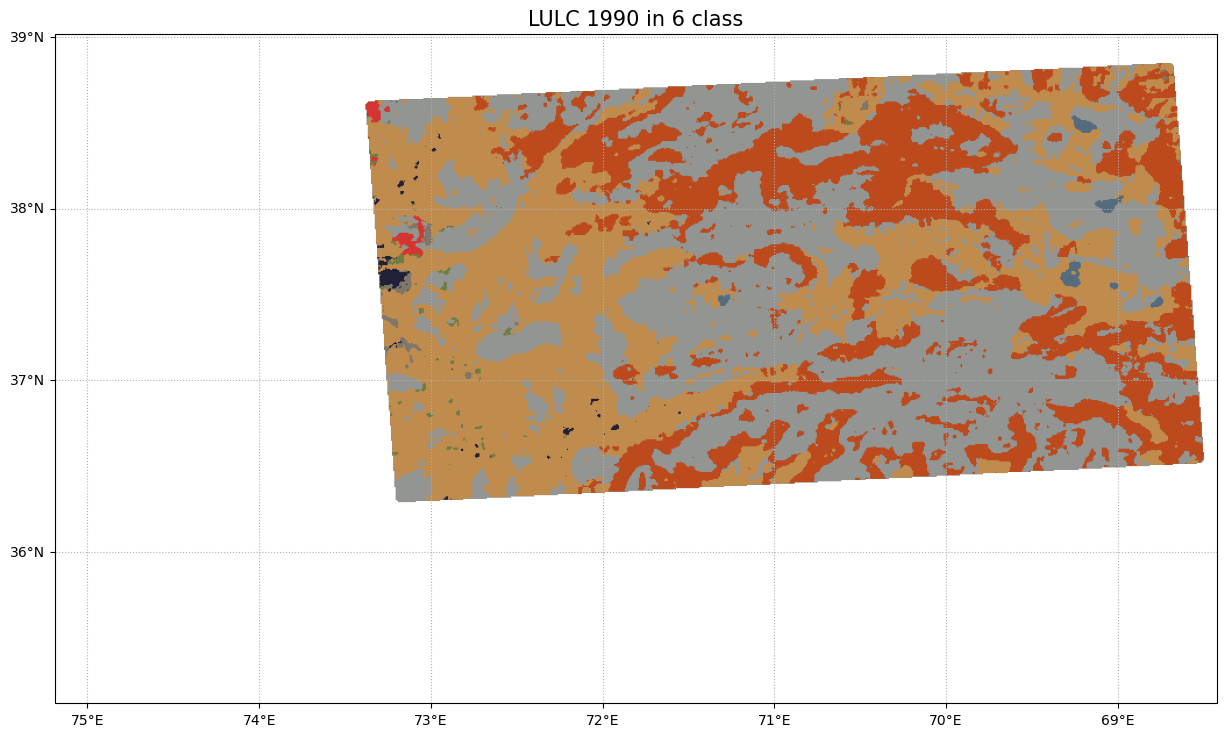

In [162]:
fig = plt.figure(figsize=(15, 10))
bbox = [68.42, 35.12, 75.19, 39.02]

ax = cartoee.get_map(afg_l0_class, vis_params=visClass, region=bbox)
cartoee.add_gridlines(ax, interval=1, xtick_rotation=0, linestyle=":")

ax.set_title(label='LULC 1990 in 6 class', fontsize=15)

In [163]:
region = ee.Geometry.BBox(68.42, 35.12, 75.19, 39.02)

geemap.ee_export_image_to_drive(
    image=afg_l0_class, 
    description='Missing_1990', 
    folder='Google Earth Engine', 
    region=region, 
    scale=30,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

In [103]:
region = ee.Geometry.BBox(68.42, 35.12, 75.19, 39.02)

bucket = 'afg-lulc-2020'

geemap.ee_export_image_to_cloud_storage(
    image=afg_l0_class,
    description='LULC_1990-04-Badakhshan.tif',
    bucket=bucket,
    region=region,
    scale=30,
    maxPixels=1e13
)

# 2000

In [15]:
imgCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterDate('2000-01-01', '2000-12-31').filterBounds(roi)
imgCol = imgCol.filter(ee.Filter.lt('CLOUD_COVER', 20))

img2000 = imgCol.reduce(ee.Reducer.percentile([20]))

img2000 = img2000.clip(roi)

img2000 = img2000.multiply(2.75e-05).add(-0.2)

ndvi_t1_00 = getNDVI(1998, 2002, 1, 2).rename('ndvi_t1')
ndvi_t2_00 = getNDVI(1998, 2002, 3, 4).rename('ndvi_t2')
ndvi_t3_00 = getNDVI(1998, 2002, 5, 6).rename('ndvi_t3')
ndvi_t4_00 = getNDVI(1998, 2002, 7, 8).rename('ndvi_t4')
ndvi_t5_00 = getNDVI(1998, 2002, 9, 10).rename('ndvi_t5')
ndvi_t6_00 = getNDVI(1998, 2002, 11, 12).rename('ndvi_t6')

kernal = ee.Kernel.square(radius=8)
kernalImg = img2000.select('SR_B5_p20').neighborhoodToBands(kernal)
swir_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

ndvi1 = img2000.expression('(NIR-RED)/(NIR+RED)', {'NIR':img2000.select('SR_B4_p20'),'RED':img2000.select('SR_B3_p20')})
kernalImg = ndvi1.neighborhoodToBands(kernal)
ndvi_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

img2000_forClass = img2000.select(['SR_B2_p20','SR_B3_p20', 'SR_B4_p20'])

img_stack_00 = ee.Image([img2000_forClass, ndvi_t1_00, ndvi_t2_00, ndvi_t3_00, ndvi_t4_00, ndvi_t5_00, ndvi_t6_00, swir_distP, ndvi_distP])

img_stack_00

In [ ]:
example_pnts = img_stack_00.sampleRegions(lc_gt_train, scale=30)

my_classifier = ee.Classifier.smileRandomForest(numberOfTrees=200).train(example_pnts, 'landcover_')

task = ee.batch.Export.classifier.toAsset(my_classifier, 'SavingRFClassfier_00', 'projects/ee-lc-trends/assets/afg_rf00')
task.start()

print(task)

In [ ]:
load_classifier = ee.Classifier.load('projects/ee-lc-trends/assets/afg_rf00')
classify_00 = img_stack_00.classify(load_classifier)
classify_00 = classify_00.focal_mode(2)

In [ ]:
fig = plt.figure(figsize=(15, 10))
bbox = [73.33, 29.46, 59.36, 38.58]

ax = cartoee.get_map(classify_00, vis_params=visClass, region=bbox)
cartoee.add_gridlines(ax, interval=1, xtick_rotation=0, linestyle=":")

ax.set_title(label='LULC 2000 in 6 class', fontsize=15)

In [ ]:
region = ee.Geometry.BBox(59.41, 29.107, 75.02, 37.54)

bucket = 'afg-lulc-2020'

geemap.ee_export_image_to_cloud_storage(
    image=classify_00,
    description='LULC_2000-01.tif',
    bucket=bucket,
    region=region,
    scale=30,
    maxPixels=1e13
)

# 2010

In [18]:
# roi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Afghanistan'))
roi = ee.FeatureCollection("projects/ee-lc-trends/assets/Anomalies_Bbox_2010-01")
training = ee.FeatureCollection("projects/ee-lc-trends/assets/Training")

imgCol = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterDate('2010-01-01', '2010-12-31').filterBounds(roi)
imgCol = imgCol.filter(ee.Filter.lt('CLOUD_COVER', 20))

img2010 = imgCol.reduce(ee.Reducer.percentile([20]))

img2010 = img2010.clip(roi)

img2010 = img2010.multiply(2.75e-05).add(-0.2)

ndvi_t1_10 = getNDVI(2008, 2012, 1, 2).rename('ndvi_t1')
ndvi_t2_10 = getNDVI(2008, 2012, 3, 4).rename('ndvi_t2')
ndvi_t3_10 = getNDVI(2008, 2012, 5, 6).rename('ndvi_t3')
ndvi_t4_10 = getNDVI(2008, 2012, 7, 8).rename('ndvi_t4')
ndvi_t5_10 = getNDVI(2008, 2012, 9, 10).rename('ndvi_t5')
ndvi_t6_10 = getNDVI(2008, 2012, 11, 12).rename('ndvi_t6')

kernal = ee.Kernel.square(radius=8)
kernalImg = img2010.select('SR_B5_p20').neighborhoodToBands(kernal)
swir_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

ndvi1 = img2010.expression('(NIR-RED)/(NIR+RED)', {'NIR':img2010.select('SR_B4_p20'),'RED':img2010.select('SR_B3_p20')})
kernalImg = ndvi1.neighborhoodToBands(kernal)
ndvi_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

img2010_forClass = img2010.select(['SR_B2_p20','SR_B3_p20', 'SR_B4_p20'])

# img_stack_10 = ee.Image([img2010_forClass, ndvi_t1_10, ndvi_t2_10, ndvi_t3_10, ndvi_t4_10, ndvi_t5_10, ndvi_t6_10, swir_distP, ndvi_distP])
img_stack_10 = ee.Image([img2010_forClass, swir_distP, ndvi_distP])

img_stack_10

In [30]:
example_pnts = img_stack_10.sampleRegions(training, scale=30)

my_classifier = ee.Classifier.smileRandomForest(numberOfTrees=200).train(example_pnts, 'landcover_')

task = ee.batch.Export.classifier.toAsset(my_classifier, 'SavingRFClassfier_10-03', 'projects/ee-lc-trends/assets/afg_rf10-03')
task.start()

print(task)

<Task 3AGN7SXNU6ND3PEWJCGAD5UU Type.EXPORT_CLASSIFIER: SavingRFClassfier_10-03 (State.UNSUBMITTED)>


In [31]:
load_classifier = ee.Classifier.load('projects/ee-lc-trends/assets/afg_rf10-03')
classify_10 = img_stack_10.classify(load_classifier)
classify_10 = classify_10.focal_mode(2)

In [32]:
Map = geemap.Map()
Map.centerObject(roi, 7)
Map.addLayer(img_stack_10, visRGB, name="Image 2010")
Map.addLayer(classify_10, visClass, name="Classify")

Map

Map(center=[36.48618219526728, 66.94581302165902], controls=(WidgetControl(options=['position', 'transparent_b…

Text(0.5, 1.0, 'LULC 2010 in 6 class')

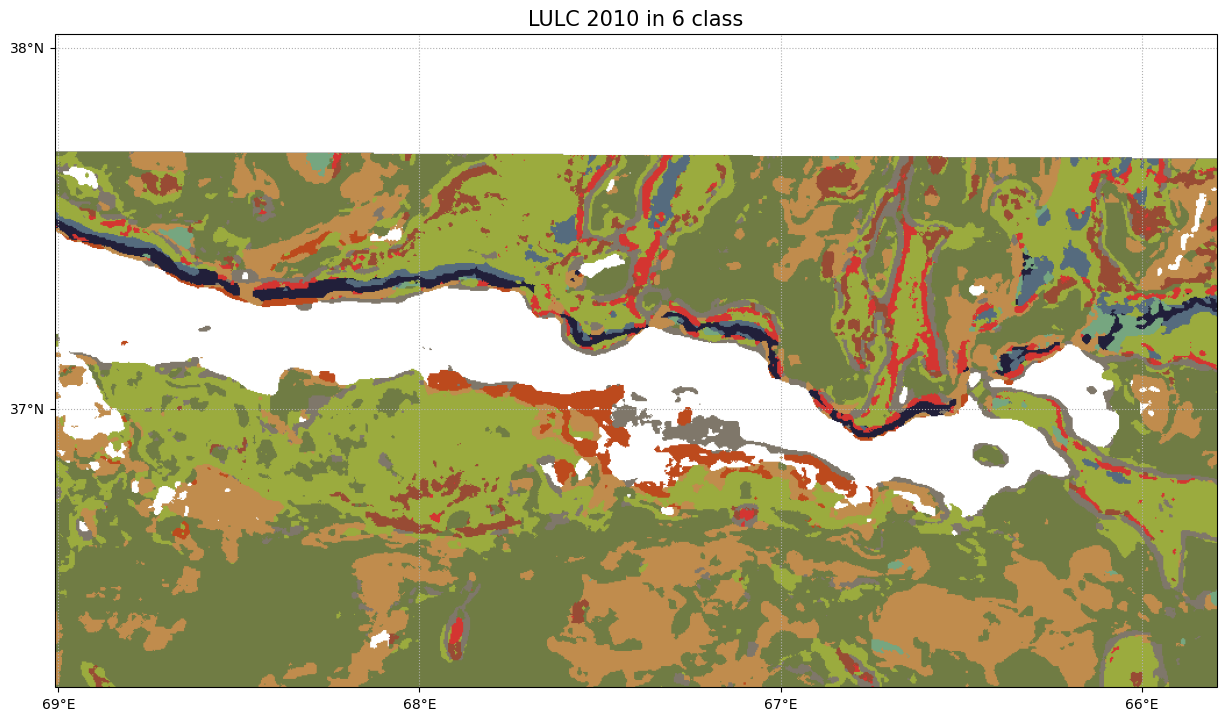

In [33]:
fig = plt.figure(figsize=(15, 10))
bbox = [65.79, 36.23, 69.01, 38.04]

ax = cartoee.get_map(classify_10, vis_params=visClass, region=bbox)
cartoee.add_gridlines(ax, interval=1, xtick_rotation=0, linestyle=":")

ax.set_title(label='LULC 2010 in 6 class', fontsize=15)

In [34]:
region = ee.Geometry.BBox(63.86, 35.59, 69.91, 38.05)

geemap.ee_export_image_to_drive(
    image=classify_10, 
    description='Missing_2010_05', 
    folder='Google Earth Engine', 
    region=region, 
    scale=30,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

In [ ]:
region = ee.Geometry.BBox(59.41, 29.107, 75.02, 38.80)

bucket = 'afg-lulc-2020'

geemap.ee_export_image_to_cloud_storage(
    image=classify_10,
    description='LULC_2010-03.tif',
    bucket=bucket,
    region=region,
    scale=30,
    maxPixels=1e13
)

# 2020

In [37]:
imgCol = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2020-01-01', '2020-12-31').filterBounds(roi)
imgCol = imgCol.filter(ee.Filter.lt('CLOUD_COVER', 20))

img2020 = imgCol.reduce(ee.Reducer.percentile([20]))

img2020 = img2020.clip(roi)

img2020 = img2020.multiply(2.75e-05).add(-0.2)

ndvi_t1_20 = getNDVI(2018, 2022, 1, 2).rename('ndvi_t1')
ndvi_t2_20 = getNDVI(2018, 2022, 3, 4).rename('ndvi_t2')
ndvi_t3_20 = getNDVI(2018, 2022, 5, 6).rename('ndvi_t3')
ndvi_t4_20 = getNDVI(2018, 2022, 7, 8).rename('ndvi_t4')
ndvi_t5_20 = getNDVI(2018, 2022, 9, 10).rename('ndvi_t5')
ndvi_t6_20 = getNDVI(2018, 2022, 11, 12).rename('ndvi_t6')

kernal = ee.Kernel.square(radius=8)
kernalImg = img2020.select('SR_B6_p20').neighborhoodToBands(kernal)
swir_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

ndvi1 = img2020.expression('(NIR-RED)/(NIR+RED)', {'NIR':img2020.select('SR_B5_p20'),'RED':img2020.select('SR_B4_p20')})
kernalImg = ndvi1.neighborhoodToBands(kernal)
ndvi_distP = kernalImg.reduce(ee.Reducer.percentile([10, 20, 30, 40, 50, 60, 70, 80, 90]))

img2020_forClass = img2020.select(['SR_B2_p20','SR_B3_p20', 'SR_B4_p20'])

img_stack_20 = ee.Image([img2020_forClass, ndvi_t1, ndvi_t2, ndvi_t3, ndvi_t4, ndvi_t5, ndvi_t6, swir_distP, ndvi_distP])

img_stack_20

In [41]:
example_pnts = img_stack_20.sampleRegions(lc_gt_train, scale=30)

my_classifier = ee.Classifier.smileRandomForest(numberOfTrees=200).train(example_pnts, 'landcover_')

task = ee.batch.Export.classifier.toAsset(my_classifier, 'SavingRFClassfier_20_1', 'projects/ee-lc-trends/assets/afg_rf20')
task.start()

print(task)

<Task V5ZGL576K3WDT7T6O653YPGU Type.EXPORT_CLASSIFIER: SavingRFClassfier_20_1 (State.UNSUBMITTED)>


In [42]:
load_classifier = ee.Classifier.load('projects/ee-lc-trends/assets/afg_rf20')
classify_20 = img_stack_20.classify(load_classifier)
classify_20 = classify_20.focal_mode(2)

Text(0.5, 1.0, 'LULC 2020 in 6 class')

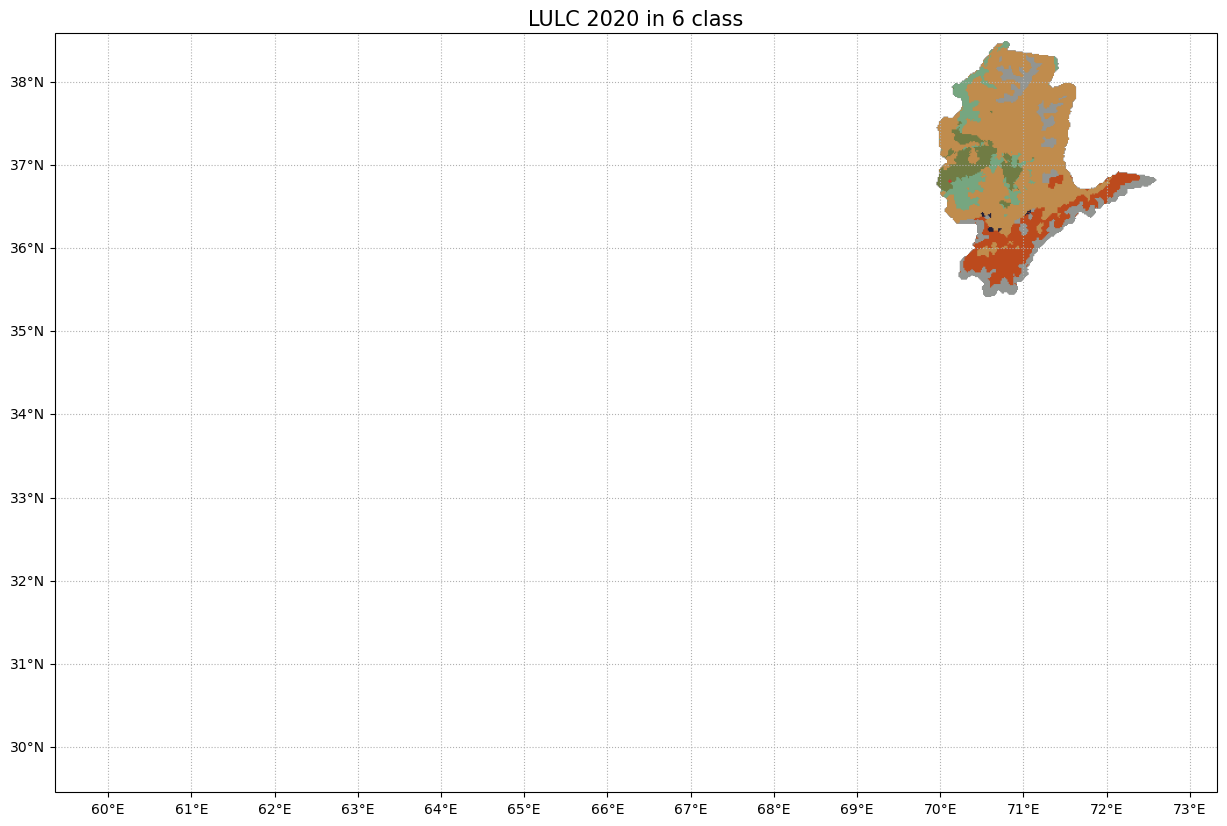

In [43]:
fig = plt.figure(figsize=(15, 10))
bbox = [73.33, 29.46, 59.36, 38.58]

ax = cartoee.get_map(classify_20, vis_params=visClass, region=bbox)
cartoee.add_gridlines(ax, interval=1, xtick_rotation=0, linestyle=":")

ax.set_title(label='LULC 2020 in 6 class', fontsize=15)

In [44]:
region = ee.Geometry.BBox(59.41, 29.107, 75.02, 38.80)

bucket = 'afg-lulc-2020'

geemap.ee_export_image_to_cloud_storage(
    image=classify_20,
    description='LULC_2020-02.tif',
    bucket=bucket,
    region=region,
    scale=30,
    maxPixels=1e13
)

In [45]:
region = ee.Geometry.BBox(60.65, 29.30, 72.18, 38.80)
geemap.ee_export_image_to_drive(
    image=classify_20,
    description='LULC_2020_drive.tif',
    folder='Google Earth Engine',
    region=region,
    scale=30,
    maxPixels=1e13,
)

In [46]:
region = ee.Geometry.BBox(60.65, 29.30, 72.18, 38.80)

Map = geemap.Map(center = [33.9, 67.7], zoom = 6)
Map.addLayer(region, {'color': 'black'}, "BBOX")


[converting to numpy](https://mygeoblog.com/2017/10/06/from-gee-to-numpy-to-geotiff/), then to raster format

In [47]:
from osgeo import gdal
from osgeo import osr
import time

In [48]:
area = ee.Geometry(region)
img = ee.Image(img_stack_20)
timedate = img.get('GENERATION_TIME').getInfo()

latlon = ee.Image.pixelLonLat()
latlon = latlon.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=area,
    scale=30,
    maxPixels=1e13,
)

In [49]:
data = np.array((ee.Array(latlon.get("nd")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

unique_lats = np.unique(lats)
unique_lons = np.unique(lons)

ncols = len(unique_lons)
nrows = len(unique_lats)

ys = unique_lats[1] - unique_lats[0]
xs = unique_lons[1] - unique_lons[0]

arr = np.zeros([nrows, ncols], np.float32)

counter = 0
for y in range(0, len(arr),1):
    for x in range(0, len(arr[0]),1):
        if lats[counter] == unique_lats[y] and lons[counter] == unique_lons[x] and counter < len(lats)-1: counter+=1
        arr [len(unique_lats)-1-y, x] = data[counter]

EEException: User memory limit exceeded.

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(arr)
plt.show()

In [ ]:
transform = (np.min(unique_lons), xs, 0, np.max(unique_lats), 0, -ys)

target = osr.SpatialReference()
target.ImportFromEPSG(4326) # wgs84

driver = gdal.GetDriverByName('GTiff')

timestring = time.strftime("%Y%m%d_%H%M%S")
output_dataset = driver.Create("./outputs/LULC-2020.tif", ncols, nrows, 1, gdal.GDT_Float32)

output_dataset.SetMetadata( {'time': str(timedate), 'yearInfo': '2020'} )
 
output_dataset.SetGeoTransform(transform)
output_dataset.SetProjection(target.ExportToWkt())
output_dataset.GetRasterBand(1).WriteArray(arr)
output_dataset.GetRasterBand(1).SetNoDataValue(-9999)
output_dataset = None

# visualization

In [ ]:
Map = geemap.Map(center = [33.9, 67.7], zoom = 6)

Map.addLayer(afg_l0_class, visClass, name="1990 LU")
Map.addLayer(classify_00, visClass, name="2000 LU")
Map.addLayer(classify_10, visClass, name="2010 LU")
Map.addLayer(classify_20, visClass, name="2020 LU")
Map

In [ ]:
example_pnts = img_stack_20.sampleRegions(lc_gt_train, scale=30)
sampled_gcp = example_pnts.randomColumn()
test_gcp = sampled_gcp.filter(ee.Filter.gte('random', 0.8))

task_val = ee.batch.Export.table.toAsset(
    collection = test_gcp.select(['lc_id', 'classification']),
    description= 'Table for Testing',
    assetId = 'projects/ee-lc-trends/assets/afg_val'
)
task_val.start()

In [ ]:
df = pd.read_csv('./Table for Testing.csv')

print(len(df[df['lc_id'] == df['classification']])/len(df['lc_id']))

for i1 in range(0,6+1):
    df_i1 = df[df['lc_id'] == i1]
    t_list = []
    for i2 in range(0,6+1):
        t_list.append(len(df_i1[df_i1['classification'] == i2]))
    t_list = np.array(t_list)
    print(i1, np.round(t_list/np.sum(t_list)*100))

# bbox generation

In [5]:
import geojson

def bbox(polygon):
    box = []
    for i in (0,1):
        res = sorted(polygon, key=lambda x:x[i])
        box.append((res[0][i], res[-1][i]))
    ret = f"({box[0][0]} {box[1][0]}, {box[0][1]} {box[1][1]})"
    return ret

polygon = geojson.Polygon("./afg/geoBoundaries-AFG-ADM0.geojson")
line = bbox(list(geojson.utils.coords(polygon)))
print(line)

ValueError: '.' is not a JSON compliant number

# Changes 

In [10]:
roi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Afghanistan'))
roi_geom = roi.geometry()

start_date = "2000-01-01"
end_date = "2010-01-01"

In [20]:
image_00 = "Microsoft.PowerShell.Core\FileSystem::\\203.159.29.25\kepler-x\A-Projects\P2023-FAO-Afg_RSIndicators\01_Analysis_data\01-LULC"
image_10 = ee.ImageCollection(img_stack_10)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'


C:\Users\april\AppData\Local\Temp\ipykernel_34668\654260118.py:1: SyntaxWarning: invalid escape sequence '\F'
  image_00 = "Microsoft.PowerShell.Core\FileSystem::\\203.159.29.25\kepler-x\A-Projects\P2023-FAO-Afg_RSIndicators\01_Analysis_data\01-LULC"
